# GradedLab 1 
## Task 3: QLearning

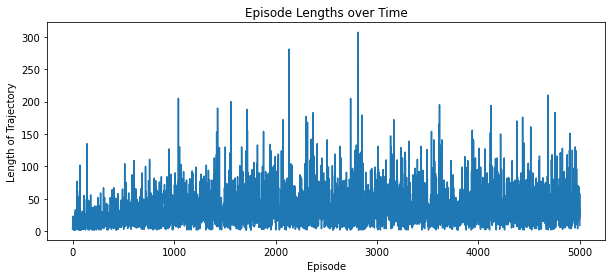

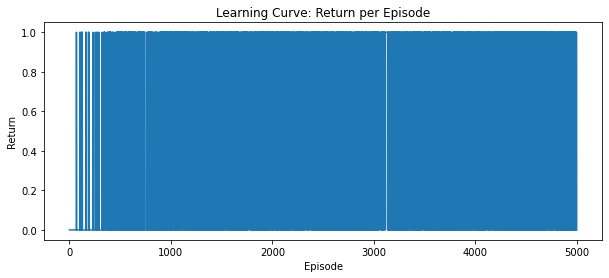

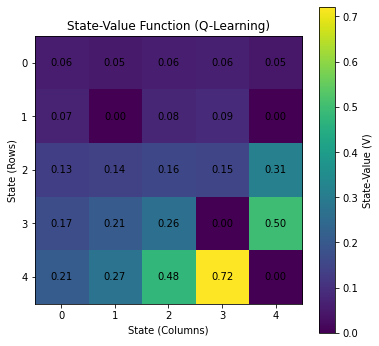

In [5]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from pathlib import Path
from typing import NamedTuple
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# Define parameters using a NamedTuple
class Params(NamedTuple):
    total_episodes: int
    gamma: float
    alpha: float
    epsilon: float
    min_epsilon: float
    epsilon_decay: float
    map_size: int
    seed: int
    is_slippery: bool
    proba_frozen: float
    savefig_folder: Path

# Initialize parameters
params = Params(
    total_episodes=5000,
    gamma=0.9,
    alpha=0.1,
    epsilon=1.0,
    min_epsilon=0.1,
    epsilon_decay=0.995,
    map_size=5,
    seed=123,
    is_slippery=True,
    proba_frozen=0.8,
    savefig_folder=Path("./_static/img"),
)

# Create the folder for saving figures if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

# Initialize the Frozen Lake environment with random map generation
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode='rgb_array', 
    desc=generate_random_map(
        size=params.map_size,
        p=params.proba_frozen,
        seed=params.seed
    ),
)

# Initialize Q-table to zeros and tracking variables
Q = np.zeros((env.observation_space.n, env.action_space.n))
episode_lengths = []
episode_returns = []

# Function to choose action using ε-Greedy policy based on Q-values
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()  # Explore: random action
    else:
        return np.argmax(Q[state])  # Exploit: action with max Q-value for the state

# Q-Learning algorithm
epsilon = params.epsilon
for episode in range(params.total_episodes):
    state, _ = env.reset()
    done = False
    episode_length = 0
    total_reward = 0

    while not done:
        # Choose action with ε-Greedy policy
        action = choose_action(state, epsilon)
        next_state, reward, done, _, *_ = env.step(action)

        # Q-Learning update
        best_next_action = np.argmax(Q[next_state])
        Q[state, action] += params.alpha * (reward + params.gamma * Q[next_state, best_next_action] - Q[state, action])

        state = next_state
        total_reward += reward
        episode_length += 1

    # Track episode length and return
    episode_lengths.append(episode_length)
    episode_returns.append(total_reward)

    # Decay ε to reduce exploration over time
    epsilon = max(params.min_epsilon, epsilon * params.epsilon_decay)

# Visualization Functions
def plot_episode_lengths(episode_lengths, title="Episode Lengths over Time"):
    plt.figure(figsize=(10, 4))
    plt.plot(episode_lengths)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Length of Trajectory")
    plt.show()

def plot_learning_curve(episode_returns, title="Learning Curve: Return per Episode"):
    plt.figure(figsize=(10, 4))
    plt.plot(episode_returns)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.show()

def plot_value_function_from_Q(Q, grid_size, title="State-Value Function from Q"):
    V = np.max(Q, axis=1).reshape((grid_size, grid_size))  # State-value derived from Q-values
    plt.figure(figsize=(6, 6))
    heatmap = plt.imshow(V, cmap="viridis", origin="upper")
    plt.colorbar(heatmap, label="State-Value (V)")
    plt.title(title)
    plt.xlabel("State (Columns)")
    plt.ylabel("State (Rows)")
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{V[i, j]:.2f}", ha="center", va="center", color="black")
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.show()

# Plot Results
grid_size = int(np.sqrt(env.observation_space.n))
plot_episode_lengths(episode_lengths)
plot_learning_curve(episode_returns)
plot_value_function_from_Q(Q, grid_size, title="State-Value Function (Q-Learning)")
